First import fastai and set key to azure search key

In [1]:
import fastbook
from fastbook import *
from fastai.vision.widgets import *
key = os.environ.get('AZURE_SEARCH_KEY', 'fa957fda6f6043899c302216963408a4')

this is an example of how to search for stuff using azure search key, also shows default amount of urls we get back

In [2]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

were gonna find three categories: grizzly, black, and teddy bears

In [3]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

this is a loop that will create a folder called bears, and include subfolders with the categories
then were going to search for each category of bears on bing and download the image

In [4]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

this code just confirms that we have done everything correct and stuff was saved

In [5]:
fns = get_image_files(path)
fns

(#391) [Path('bears/grizzly/da897ab3-020b-4ac1-aa52-72898a867a89.jpg'),Path('bears/grizzly/cd8519f6-a92f-4d70-9479-1e8121155b29.jpg'),Path('bears/grizzly/a61a3ccc-bca7-4a18-af54-0b7d136c06c8.jpg'),Path('bears/grizzly/59a14cd2-09c2-4c1a-a33b-4383226387a2.jpg'),Path('bears/grizzly/f40a3661-6d81-479a-a3ea-095dbebd1a4f.jpg'),Path('bears/grizzly/3824726b-2129-458f-8d68-3d3fcc363099.jpg'),Path('bears/grizzly/19804e79-b09e-40d6-b8a3-6d284fb68cb7.jpg'),Path('bears/grizzly/bdb75b1b-2713-4da5-8535-c0fa7300f903.jpg'),Path('bears/grizzly/ec5c5f6c-be45-419d-9166-6dea2721ceca.jpg'),Path('bears/grizzly/aca7fbb5-3afe-4ed6-a34d-e98f9d8cc557.jpg')...]

sometimes images wont be installed correctly so we wanna verify them to make sure theyre all ok

In [6]:
failed = verify_images(fns)
failed

(#0) []

if any images are corrupted, lets unlink them from the path object so they're not included`

In [7]:
failed.map(Path.unlink)

(#0) []

we need to create a dataloaders object for the dataset that we just downloaded.
this is how data is provided for the model
1. provide a tuple where we specify what types we want for IV and DV (imageblock, categoryblock)
        IV used to make predictions from
        DV is our target
2. our items fro the dataloaders object will be file paths, and we tell fastai how to get a list of those files
3. we define how the dataset is split into validation and training, include a seed so we get same list every time
4. parent_label gets the name of the folder a file is in (each bear image in in folder corresponding with its label)
5. we gotta make sure that all images are the same size so we use the resize transformer

In [8]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

the previous command gave us a datablock object, a template for creating DataLoaders, now we need to tell fastai the source of our data

In [9]:
dls = bears.dataloaders(path)

/home/one6ix/Desktop/fastai/ch1/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


now we wanna make sure that our dataset has been processed properly, labels are correct, images are same size, etc. for each batch sent to GPU

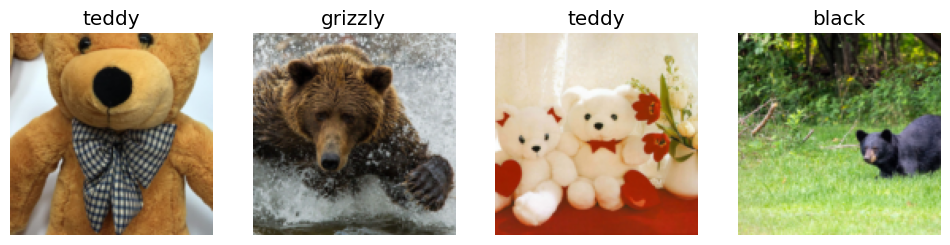

In [10]:
dls.valid.show_batch(max_n=4, nrows=1)

This is one of the ways we can resize images (not good), model may think bears are shaped this way (not true)

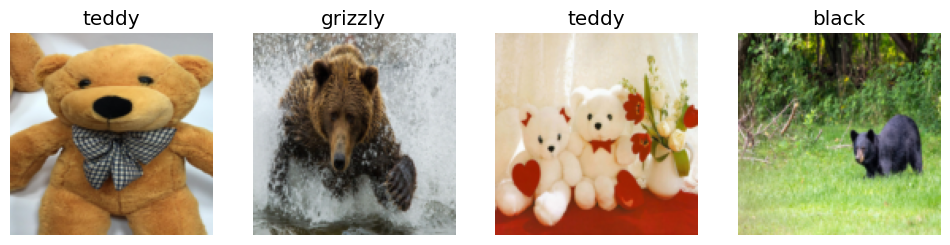

In [11]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Another way to resize (also not good), waste computation

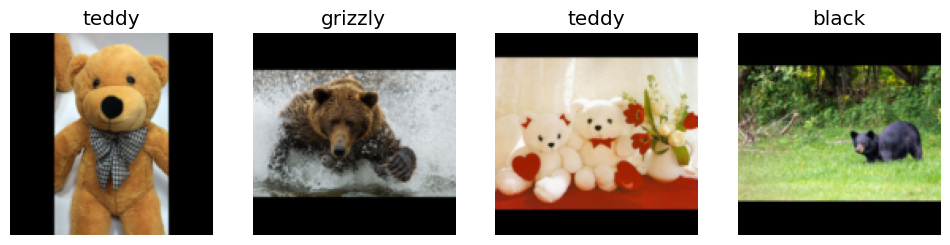

In [12]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

one of the best ways is to randomly select a feature in the image and crop to it -> lets model better recognize what an object is.

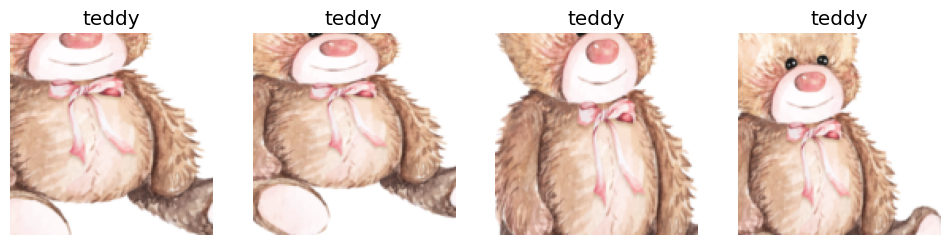

In [13]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

to give it more of an idea what an object is we can mess with perspective, rotation, brightness, contrast, etc. but keep the same meaning for each image

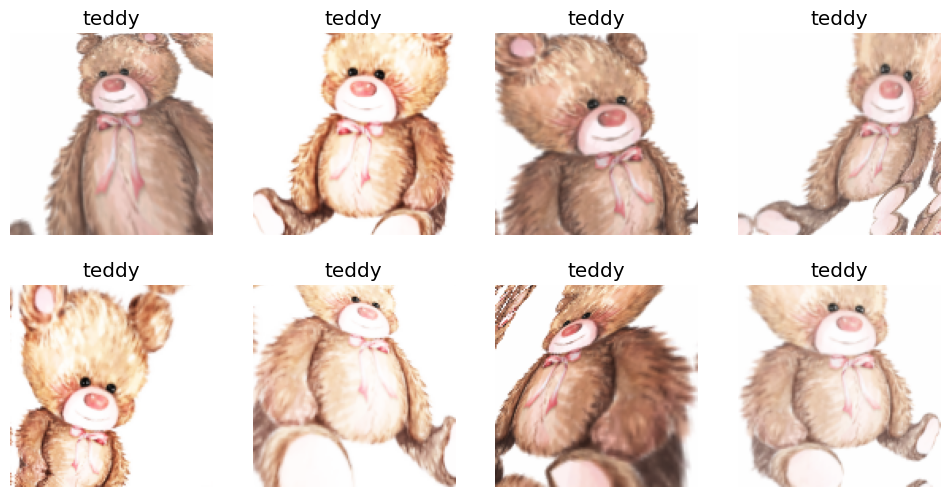

In [14]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

we dont have a lof of data for our problem so well use randomresizedcrop with image size 224px (standard for image classification) and use default aug_transforms

In [15]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

now were going to create our learner, fine-tune it in the usual way

In [16]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.971399,0.181595,0.051282,00:10


/home/one6ix/Desktop/fastai/ch1/.venv/lib/python3.12/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.397054,0.139406,0.038462,00:12
1,0.246590,0.126507,0.025641,00:12
2,0.182320,0.120146,0.025641,00:12
3,0.151272,0.109251,0.025641,00:12


/home/one6ix/Desktop/fastai/ch1/.venv/lib/python3.12/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/one6ix/Desktop/fastai/ch1/.venv/lib/python3.12/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/one6ix/Desktop/fastai/ch1/.venv/lib/python3.12/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/one6ix/Desktop/fastai/ch1/.venv/lib/python3.12/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


now were going to see whether the mistakes the model is making are thinking grizzlies are teddies or some other combination
-   column represent images model predicted
-   row represent all bears in our dataset
-   diagonal are correct
-   ideally off-diagonal are all 0 (white)

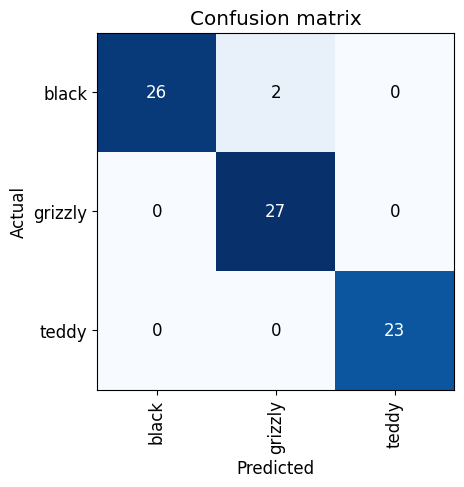

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Now we want to see the images with the highest loss in our dataset (to find out exactly what errors are occurring)

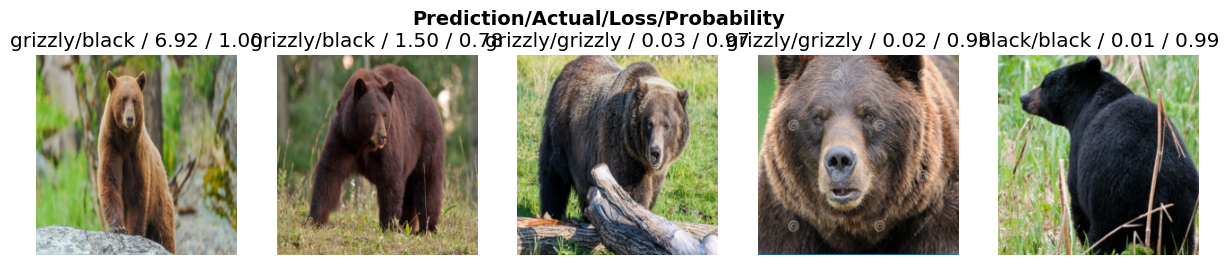

In [18]:
interp.plot_top_losses(5, nrows=1)

this code should present a nice GUI for us to clean the dataset but it took >10mins to load

In [ ]:
# #hide_output
# cleaner = ImageClassifierCleaner(learn)
# cleaner

Now were going to save the model

In [19]:
learn.export()

Confirm that the model is saved

In [20]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

create an inference of the model so that we can get predictions for one image at a time

In [21]:
learn_inf = load_learner(path/'export.pkl')

so we get prediction of an image (hopefully it hasn't seen before)

In [22]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([1.9273e-02, 9.7980e-01, 9.2404e-04]))

to find out what tensor(1) means we list the vocab and match the index to the array printed below:

In [23]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

now were going to try and make a web-app where users can upload an image and the model's prediction will output

In [24]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [25]:
img = PILImage.create(btn_upload.data[-1])

this is to confirm with user what they've uploaded (not sure why four are being printed...)

In [34]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

now were gonna extract the prediction data outputted from the predict method. 
- pred: probability the image is this category
- pred_idx: category it predicted (index in probs)

In [27]:
pred,pred_idx,probs = learn_inf.predict(img)

In [28]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.9798')

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [30]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

top two code boxes just make a button that will feed the image to the model and print out what it thinks it is

this will set a variable used for VBOX below:

In [31]:
btn_upload = widgets.FileUpload()

In [37]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])